In [ ]:
%pip install pandas
%pip install matplotlib
%pip install seaborn

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [26]:
train.head(5)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


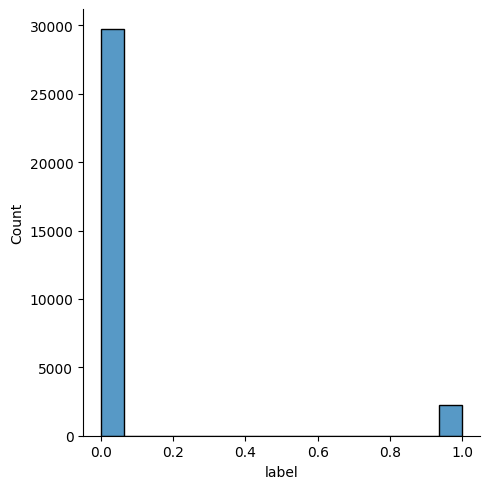

In [27]:
sns.displot(train['label'])

In [28]:
label = train['label']
train = train.drop('label', axis=1)
train

,id,tweet
0,1,@user when a father is dysfunctional and is s...
1,2,@user @user thanks for #lyft credit i can't us...
2,3,bihday your majesty
3,4,#model i love u take with u all the time in ...
4,5,factsguide: society now #motivation
...,...,...
31957,31958,ate @user isz that youuu?ðððððð...
31958,31959,to see nina turner on the airwaves trying to...
31959,31960,listening to sad songs on a monday morning otw...
31960,31961,"@user #sikh #temple vandalised in in #calgary,..."


In [30]:
combined = pd.concat([train, test], axis=0)
combined

,id,tweet
0,1,@user when a father is dysfunctional and is s...
1,2,@user @user thanks for #lyft credit i can't us...
2,3,bihday your majesty
3,4,#model i love u take with u all the time in ...
4,5,factsguide: society now #motivation
...,...,...
17192,49155,thought factory: left-right polarisation! #tru...
17193,49156,feeling like a mermaid ð #hairflip #neverre...
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...
17195,49158,"happy, at work conference: right mindset leads..."


In [31]:
tweets = train['tweet']
count_words = tweets.str.findall(r'\w+').str.len()
print(count_words.sum())

443676


In [ ]:
%pip install nltk

import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

""" Cleaning the tweets """
tweets = tweets.str.lower()

# removing special characters and numbers
tweets = tweets.apply(lambda x: re.sub(r'\d+', '', x))

# remove hashtags
tweets = tweets.str.replace('#', '')

# remove words less than 2 characters
tweets = tweets.apply(lambda x: ' '.join([word for word in x.split() if len(word)>2]))

# remove stopwords
stopwords = set(stopwords.words('english'))
tweets = tweets.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

In [34]:
most_freq_words = pd.Series(' '.join(tweets).split()).value_counts()[:25]
tweets = tweets.apply(lambda x: ' '.join([word for word in x.split() if word not in most_freq_words]))
print(most_freq_words)

count_words = tweets.str.findall(r'\w+').str.len()
print(count_words.sum())

@user       17296
love         2562
day          1694
&amp;        1580
happy        1437
i'm           993
like          990
â¦           988
new           967
time          955
positive      917
thankful      914
get           906
life          881
good          789
bihday        770
people        748
see           736
can't         729
one           696
smile         639
want          616
take          613
today         607
healthy       585
Name: count, dtype: int64
254666


In [35]:
from collections import Counter
from itertools import chain

# Split the words into a list
v = tweets.str.split().tolist()

# Compute global word frequency
c = Counter(chain.from_iterable(v))

# Filter, join, and re-assign
tweets = [' '.join([j for j in i if c[j] > 1]) for i in v]

total_word = 0
for x,word in enumerate(tweets):
    total_word += len(word.split())

print(total_word)

192990


In [ ]:
import spacy
import spacy.cli
spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm')

In [50]:
import en_core_web_sm

nlp = en_core_web_sm.load()
document = nlp(tweets[0])
print("Document is: ", document)
print("Tokens :  ")
for token in document:
    print(token.text)

Document is:  father selfish drags kids dysfunction. run
Tokens :  
father
selfish
drags
kids
dysfunction
.
run


In [52]:
document = nlp(tweets[0])
print("Document is: ", document)
for token in document:
    print(token.text, token.vector.shape)

Document is:  father selfish drags kids dysfunction. run
father (96,)
selfish (96,)
drags (96,)
kids (96,)
dysfunction (96,)
. (96,)
run (96,)


In [54]:
import numpy as np

# Process the tweets using nlp.pipe
documents = list(nlp.pipe(tweets))

# Determine the maximum length of the vectors
max_length = max(len(doc.vector) for doc in documents)

# Pad the vectors to ensure they all have the same length
padded_vectors = [np.pad(doc.vector, (0, max_length - len(doc.vector)), 'constant') for doc in documents]

# Create the NumPy array with the padded vectors
tweets_vector = np.array(padded_vectors)

print(tweets_vector.shape)

(31962, 96)


In [55]:
X = tweets_vector
y = label

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=1)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((22373, 96), (9589, 96), (22373,), (9589,))

In [58]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=10, max_iter=1000).fit(X_train, y_train)
print(model.score(X_train, y_train))

0.9295579493139051


In [59]:
y_pred = model.predict(X_val)
print(model.score(X_val, y_val))

0.9298154134946293


In [60]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[8913    3]
 [ 670    3]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      8916
           1       0.50      0.00      0.01       673

    accuracy                           0.93      9589
   macro avg       0.72      0.50      0.49      9589
weighted avg       0.90      0.93      0.90      9589

